# Frozen Lake + CNN + Target network + experience replay
![](frozenLake2.gif "frozen lake ")

In [22]:
%reset -f
import numpy as np
import torch
from IPython.display import clear_output
from IPython import display
import random
import matplotlib.pylab as plt
import copy
import gym

import torch.nn as nn
import torch.nn.functional as F

from gym.envs.toy_text.frozen_lake import generate_random_map

In [23]:
gSize = 4 # grid size
nH = 2.    # desired number of hole: this is probabilistic
pH = 1 - nH/(gSize*gSize) # probability of  grid being a hole

desc = generate_random_map(size= gSize, p= pH)

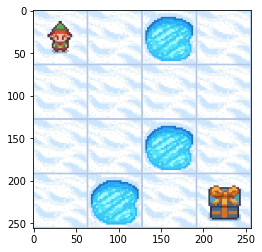

In [24]:
env = gym.make('FrozenLake-v1', desc=desc,map_name=None, is_slippery=False)
env.reset()
plt.imshow(env.render(mode="rgb_array"))

In [26]:
def oneHot(s,h=0):
    x = np.zeros(gSize*gSize)
    x[s] = 1
    state_ = np.array([ x.reshape(gSize,gSize),
                     np.array(env.desc == b"F").astype("float64"),
                     np.array(env.desc == b"G").astype("float64")
                      ])
    return state_ + h*np.random.rand(state_.size).reshape(state_.shape)

In [33]:
env = gym.make('FrozenLake-v1', desc=desc,map_name=None, is_slippery=False)
env.reset()
state_ = oneHot(0)
state_ = torch.tensor(state_).float()

class  MyModel(nn.Module):

    def __init__(self):
        super(MyModel, self).__init__()
        self.mainLayer = nn.Sequential(
                nn.Conv2d(3,12,kernel_size=3,stride= 1,padding=1),
                nn.ReLU(),
                nn.Conv2d(12,24,kernel_size=3,stride=1,padding=1),
                nn.ReLU(),
                nn.Conv2d(24,36,kernel_size=3,stride=1,padding=1),
                nn.ReLU(),            
                nn.Flatten(start_dim=-3,end_dim=-1),
                nn.Linear(576,1200),
                nn.ReLU(),
                nn.Linear(1200,64),
                nn.ReLU(),
                nn.Linear(64,4),
        )

    def forward(self, x):
        x = self.mainLayer(x)
        return x

model = MyModel()

print(state_.shape)
model(state_).shape

torch.Size([3, 4, 4])


torch.Size([4])

In [34]:
model2 = copy.deepcopy(model)
model2.load_state_dict(model.state_dict())

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

In [38]:
from collections import deque
import sys

epochs = 5001
#losses = []
mem_size = 1000
batch_size = 200
replay = deque(maxlen=mem_size)
max_moves = 50
h = 0
sync_freq = 500
j = 0

for i in range(epochs):
    env = gym.make('FrozenLake-v1', 
                   desc=generate_random_map(size= gSize, p= pH),
                   map_name=None, is_slippery=False)
    env.reset()
    state_ = oneHot(0,h=1)
    state1 = torch.tensor(state_).float()

    status = 1
    mov = 0
    s1 = 0
    while (status == 1):
        j += 1
        mov += 1
        qval = model(state1)
        qval_ = qval.data.numpy()
        action = np.argmax(qval_) if random.random() < epsilon else np.random.randint(0,4)
        s2, reward, done, _ = env.step(action)
        #modify the reward
        if done:
            reward = 10 if s2 == gSize*gSize-1 else -10
        elif s2 == s1: # going out of grid
            reward = -5
            done = True            
        else:
            reward = -1
        s1 = s2
        
        
        state_ = oneHot(s2,h=1)
        state2 = torch.tensor(state_).float()
        exp = (state1, action, reward, state2, done)
        replay.append(exp)
        state1 = state2
        
        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.stack([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.stack([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])  
            Q1 = model(state1_batch)
            with torch.no_grad():
                Q2 = model2(state2_batch)
            Y = reward_batch + gamma*((1-done_batch)*torch.max(Q2,dim=1)[0])
            X = Q1.gather(dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X,Y.detach())
            # print(i,loss.item())
            # clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()      
        
        
            if j % sync_freq == 0:
                model2.load_state_dict(model.state_dict())
        if done == True or mov > max_moves:
            status = 0
            mov = 0
    if i %1000 == 0:
        torch.save(model, "savedModels/model_frozenLake_"+str(i) +".pth")
#losses = np.array(losses)
print("done")

done


Text(0, 0.5, 'Loss')

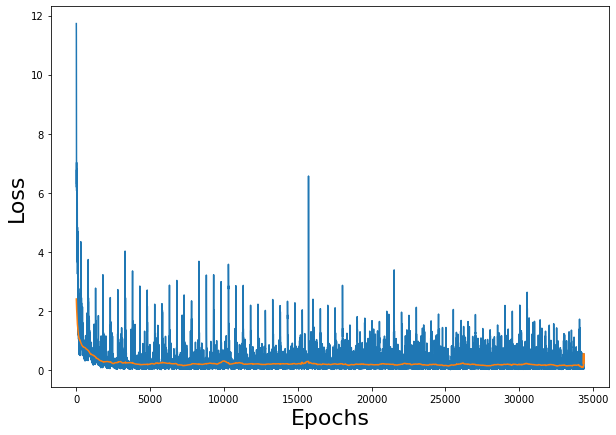

In [39]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.plot([np.mean(losses[i:i+500]) for i in range(len(losses))])
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

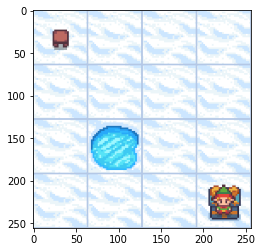

game: 19 , move:  8 , won:  19 ,lost: 1 action:  2


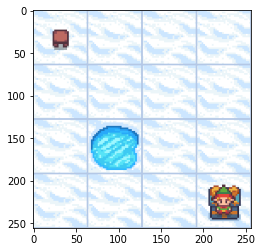

In [55]:
# lets play
import time
won = 0
lost = 0
for iii in range(20):
    plt.cla()
    env = gym.make('FrozenLake-v1', 
                   desc=generate_random_map(size= gSize, p= pH),
                   map_name=None, is_slippery=False)
    env.reset()
    state_ = oneHot(0,h=1)
    state = torch.tensor(state_).float()
    qval = model(state) #H
    qval_ = qval.data.numpy()
    action = np.argmax(qval_)
   
    status = 1 #F
    i = 0
    while(status == 1): #G
    #for j in range(1):
        print("game:", iii, ", move: ", i, ", won: ", won, ",lost:", lost, "action: ", action)

        
        s, reward, done, _ =  env.step(action)
        i += 1
        state_ = oneHot(s,h=1)
        state1 = torch.tensor(state_).float()
        qval = model(state1) #H
        qval_ = qval.data.numpy()
        action = np.argmax(qval_)
        
        if i > 50 or done == True:
            status = 0
            if reward > 0:
                won += 1
            else:
                lost +=1 
        plt.imshow(env.render(mode="rgb_array"))
        time.sleep(0.1)
            
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.gcf()
print("game:", iii, ", move: ", i, ", won: ", won, ",lost:", lost, "action: ", action)

In [29]:
#check the counter for loss and win